In [5]:
# Data update functionality
import os

from fabric import ThreadingGroup,Connection
from fabric.transfer import Transfer

# global configuration parameters
hosts = ["52.13.145.44", "52.89.179.9", "54.191.161.231", "54.218.172.167", "54.218.29.151", "54.245.161.6","54.189.189.146","34.221.228.54"]
key_file_loc = "~/.ssh/beam_competitions_key.pem"
dest_root = "/Users/sfeygi/current_code/others/prize_starter_kit/search-output/random/"

def connect_parallel(hosts,key_file_loc):
    return ThreadingGroup(*hosts,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def connect_single(host, key_file_loc):
    return Connection(host,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def run(cmd, connection):
    return connection.run(cmd)

def run_n(cmd, connections):
    return [run(cmd,connection) for connection in connections]

def rsync_results(hostname, host_ip, key_file_loc, dest_root):
    return os.system(
        'rsync -avz -e "ssh -i {key_file_loc}" ubuntu@{host_ip}:/home/ubuntu//Uber-Prize-Starter-Kit/search-output-Exploration_1-random_inputs/ {dest_root}{hostname} --exclude="*/ITERS/" --exclude="*/output*" --exclude="*/competition/viz/" --exclude="*/summaryStats/"'.format(
            dest_root=dest_root,key_file_loc=key_file_loc, hostname=hostname, host_ip=host_ip))

# global other
host_names = ["host{}".format(str(i + 1)) for i in range(len(hosts))]
connection = connect_parallel(hosts,key_file_loc)

In [3]:
# try:
#     run('cd /home/ubuntu/Uber-Prize-Starter-Kit/utilities &&  \
#         git pull origin vgv/#55-adapt_ramdom_search', connection)
# except UnexpectedExit:
#     print("Already pulled in latest!")
# Ensure that docker image on server is latest (somewhat orthogonal to this notebook, but leaving here for now)
run('docker pull beammodel/beam-competition:0.0.1-SNAPSHOT',connection)


GroupException: {<Connection host=52.13.145.44 user=ubuntu>: FileNotFoundError(2, 'No such file or directory'), <Connection host=52.89.179.9 user=ubuntu>: FileNotFoundError(2, 'No such file or directory'), <Connection host=54.191.161.231 user=ubuntu>: FileNotFoundError(2, 'No such file or directory'), <Connection host=54.218.172.167 user=ubuntu>: FileNotFoundError(2, 'No such file or directory'), <Connection host=54.218.29.151 user=ubuntu>: FileNotFoundError(2, 'No such file or directory'), <Connection host=54.245.161.6 user=ubuntu>: FileNotFoundError(2, 'No such file or directory'), <Connection host=54.189.189.146 user=ubuntu>: FileNotFoundError(2, 'No such file or directory'), <Connection host=34.221.228.54 user=ubuntu>: FileNotFoundError(2, 'No such file or directory')}

In [6]:
# Pull latest results from server
[rsync_results(hostname, host_ip, key_file_loc,dest_root) for hostname, host_ip in zip(host_names, hosts)]

[0, 0, 0, 0, 0, 0, 0, 0]

In [7]:
import pandas as pd, numpy as np, seaborn as sns
import dask.dataframe as dd
from collections import defaultdict
import re
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [8]:
%matplotlib inline

In [9]:
# Parsing utilities
def split_range(range_repr):
    """
    Split's out a mathematial range representation into its component bounds.
    
    Exclusive ('(',')') bounds will have the left and/or right bounds properly
    augmented with +1 and -1, respectively. Inclusive bounds ('[',']') will remain
    as written.
    
    Parameters
    ----------
    range_repr : str
        A formatted representation of the range with exclusive and inclusive
        bounds represented as '(',')' and/or '[',']', respectively, for example,
        the range "(300:500]" represents all numbers between 300 (exclusive) and 500
        (inclusive).
    
    Returns
    -------
    str
        The input range representation as pair of integers with the ':' remaining to permit
        easy splitting with the series `str.split` function when the `expand` argument is `True`.
    
    Examples
    --------
    >>> split_range("(47000:202000]")
    '47001:202000'
    >>> split_range("(47000:202000]")
    '155000:176000'
    
    """
    if isinstance(range_repr,float):
        return "0:120"
    l,r = range_repr.strip("(),[]").split(":")
    l = int(l) + 1 if range_repr[0] is '(' else int(l) + 0
    r = int(r) - 1 if range_repr[-1] is ')' else int(r) + 0
    return "{}:{}".format(l,r)

# input_db = pd.concat(all_input_dfs).set_index("output_key")
def concat_and_set_index(df,name):
    return pd.concat(df[name]).set_index("output_key")
def expand_range_column(in_df,field):
    in_series = in_df.loc[:,field]
    in_df = in_series.apply(split_range).str.split(":",expand=True)
    in_df.columns = ["{}_low".format(field),"{}_high".format(field)]
#     in_df
    return in_df

def split_input_range(input_df,input_fields):
    tmp_res = []
    for input_field in input_fields:
        split_input_field=expand_range_column(input_df,input_field)
        input_df.drop(input_field,axis=1,inplace=True)
        tmp_res.append(split_input_field)
    input_type_df = pd.concat(tmp_res,axis=1)
    return pd.concat([input_df,input_type_df],axis=1)

def merge_input_type_df_with_score(input_df,scores_df,score_type):
    sub_scores = scores_df.loc[score_type]
    score_df = pd.merge(sub_scores,input_df,how="outer",right_index=True,left_on="output_key").set_index("output_key")
    return score_df.dropna(axis=0)

In [10]:
class InputScoreData:
    def __init__(self,input_name, input_df, score_df):
        self.input_name = input_name
        self.input_df  = input_df
        self.score_df = score_df

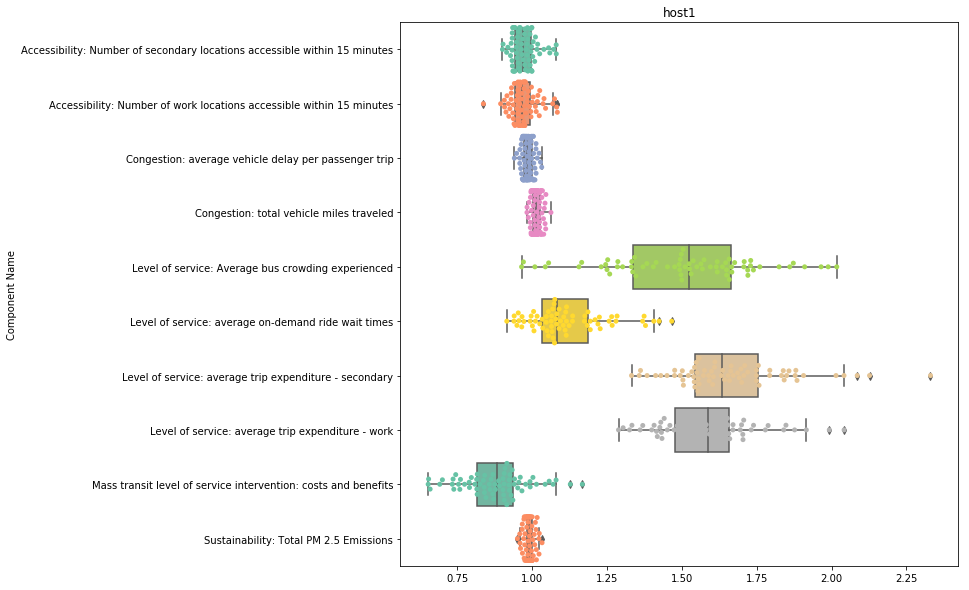

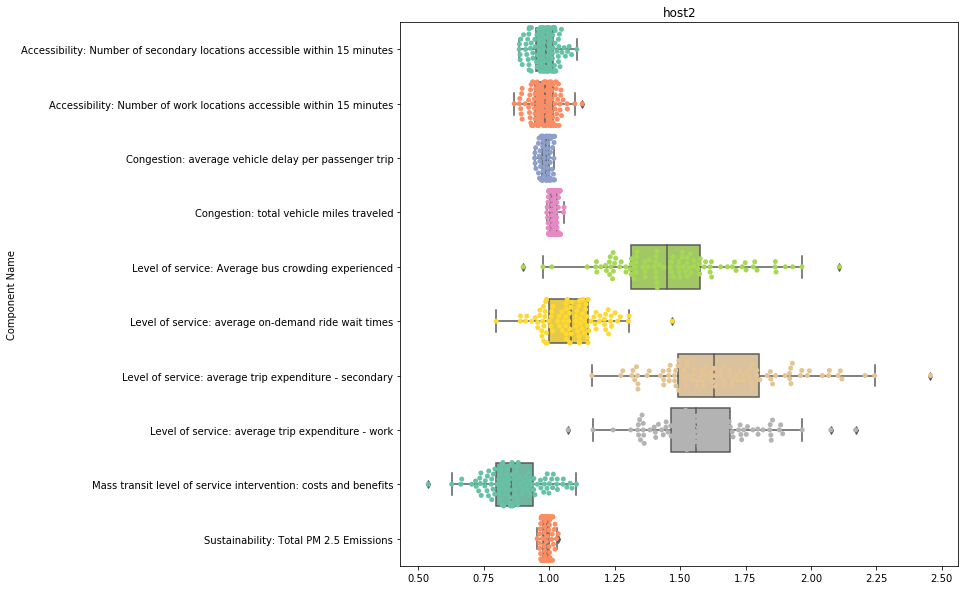

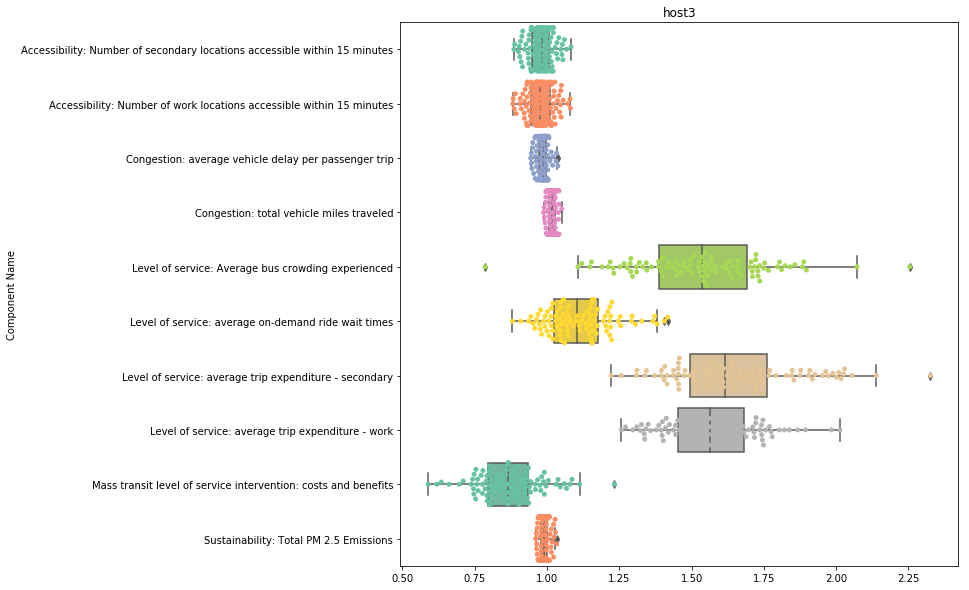

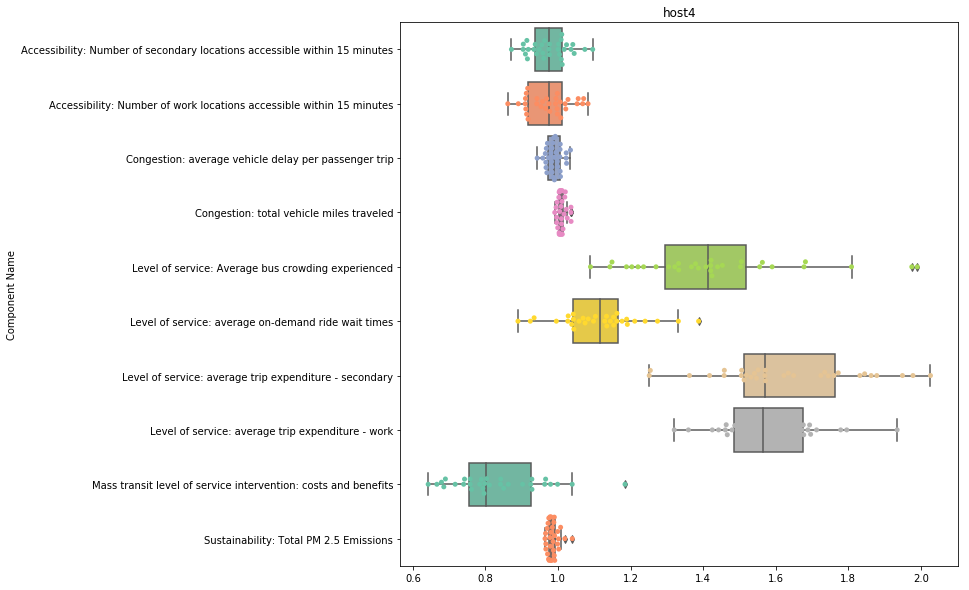

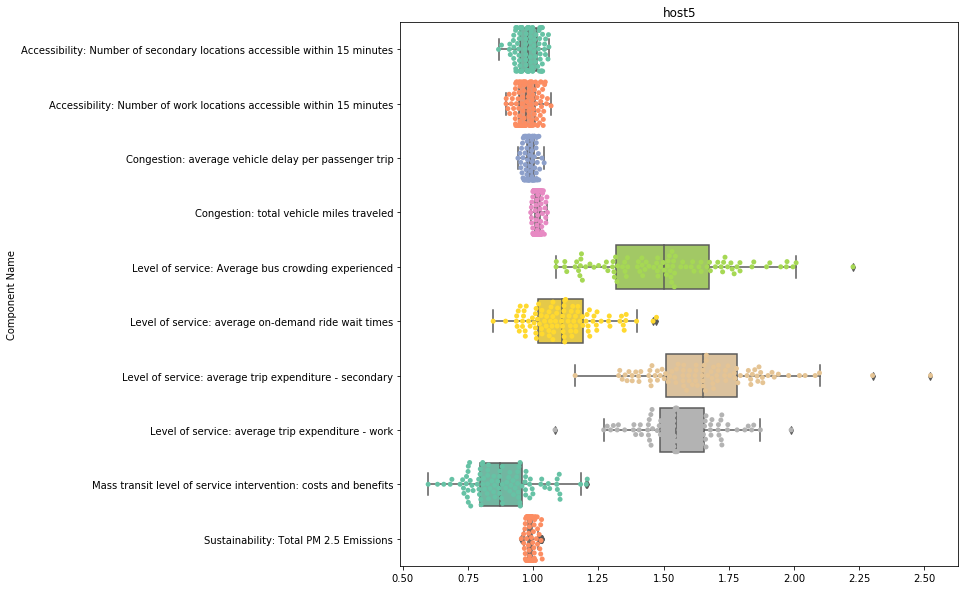

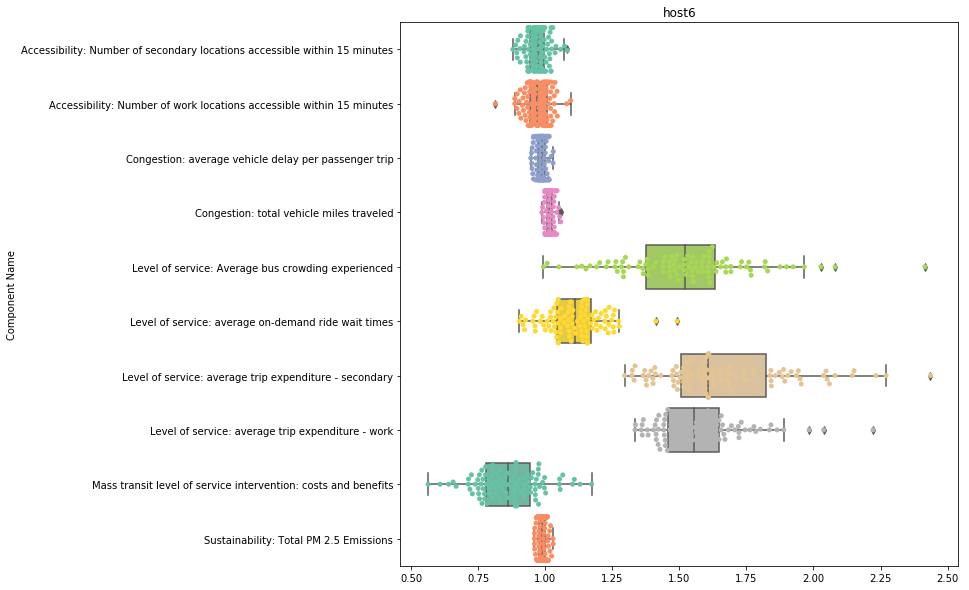

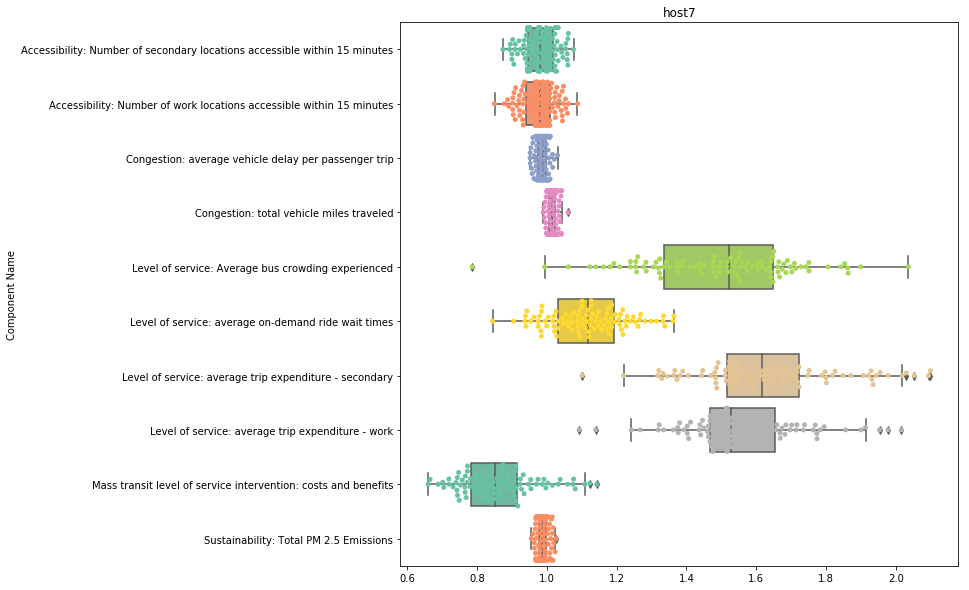

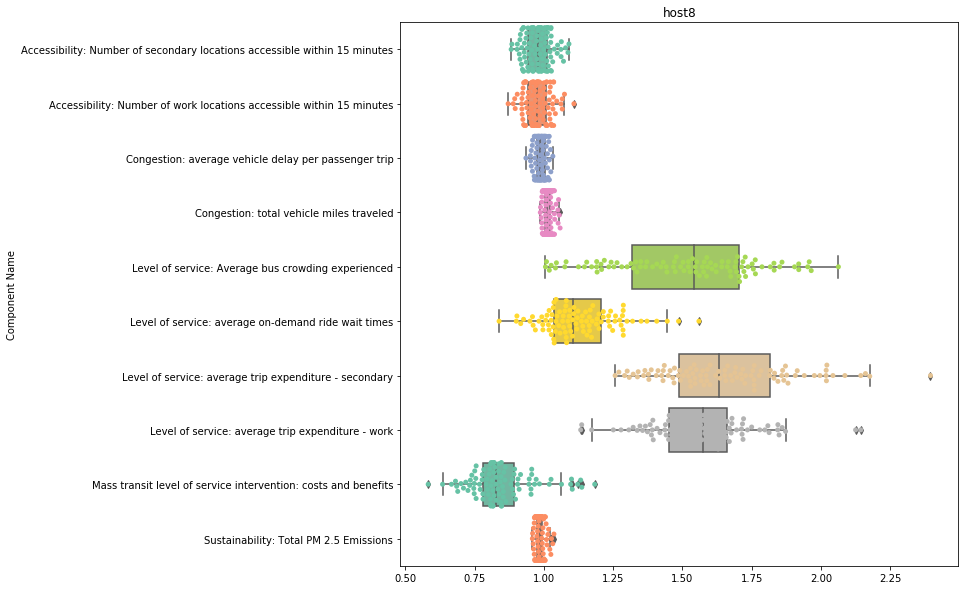

In [12]:
# collect, parse, and concatenate scores as well as plot by condition
import glob
experiment_type = 'random'
scores_dfs={}
for host in host_names:
    common="../search-output/{}/{}/".format(experiment_type,host)
    output_dirs = glob.glob(common+"output*/sioux_faux/sioux_faux-15k*/competition/")


    sub_score_dfs = []
    all_input_dfs = defaultdict(list)
    SUBMISSION_INPUTS_DIR_NAME = "submission-inputs/"
    SUB_SCORE_NAME = "submissionScores.csv"
    input_names = ("FrequencyAdjustment","ModeIncentives","PtFares","VehicleFleetMix")

    for output_dir in output_dirs:
        # Load sub_score_dfs
        sub_score_file = output_dir + SUB_SCORE_NAME
        if not Path(sub_score_file).is_file():
            continue
        score_df = pd.read_csv(sub_score_file,index_col="Component Name")
        output_key = re.findall("^.*output[_|-](.*?)(?:/sioux.*)$",output_dir)[0]
        if "RS" not in output_key:  # filter out old runs for now
            continue
        score_df["output_key"] = output_key
        sub_score_dfs.append(score_df[["Raw Score","output_key"]])

        for input_name in input_names:
            input_file = output_dir + SUBMISSION_INPUTS_DIR_NAME +"/"+ input_name+".csv"
            if input_name == 'ModeIncentives':
                input_df = pd.read_csv(input_file,dtype={'age':str})
            else:
                input_df = pd.read_csv(input_file)
            if input_df.shape[0] == 0:
                continue
            input_df["output_key"] = output_key
            input_df.index.name = 'obs_num'
            all_input_dfs[input_name].append(input_df)


    freq_df = concat_and_set_index(all_input_dfs,"FrequencyAdjustment").drop('exact_times',axis=1)
    mode_df = concat_and_set_index(all_input_dfs,"ModeIncentives")
    ptfare_df = concat_and_set_index(all_input_dfs,"PtFares")
    vfm_df = concat_and_set_index(all_input_dfs,"VehicleFleetMix").drop("agencyId",axis=1)

    trip_id_factors = pd.factorize(freq_df.loc[:,"trip_id"])
    freq_df.loc[:,"trip_id"]=trip_id_factors[0]

    mode_factors = pd.factorize(mode_df.loc[:,"mode"])
    mode_df.loc[:,"mode"]=mode_factors[0]

    a,b = pd.factorize(list(set(ptfare_df.loc[:, "routeId"].values).union(set(ptfare_df.loc[:,"routeId"]))))
    mapping = dict(zip(b,a))
    ptfare_df.loc[:,"routeId"]=ptfare_df.loc[:,"routeId"].apply(lambda x: mapping[x])
    vfm_df.loc[:, "routeId"] = vfm_df.loc[:, "routeId"].apply(lambda x: mapping[x])

    vehicle_type_factors = pd.factorize(vfm_df.loc[:,"vehicleTypeId"])
    vfm_df.loc[:,"vehicleTypeId"] = vehicle_type_factors[0]

    input_type = "ModeIncentives"
    input_fields = ["income","age"]
    mode_df = split_input_range(mode_df.copy(),input_fields)

    input_type = "PtFares"
    input_fields = ["age"]
    ptfare_df = split_input_range(ptfare_df.copy(),input_fields)

    scores_df = pd.concat(sub_score_dfs)

    score_type = "Submission Score"
    freq_subscore_df = merge_input_type_df_with_score(freq_df,scores_df,score_type)
    mode_subscore_df = merge_input_type_df_with_score(mode_df,scores_df,score_type)
    ptfare_subscore_df = merge_input_type_df_with_score(ptfare_df,scores_df,score_type)
    vfm_subscore_df = merge_input_type_df_with_score(vfm_df,scores_df,score_type)

    freq_subscore_df=freq_subscore_df[freq_subscore_df["Raw Score"]>0]
    scores_df_wide = scores_df.reset_index().pivot(index='output_key',columns='Component Name',values='Raw Score')
    scores_dfs[host] = scores_df_wide
    fig = plt.figure(figsize=(10,10))
    sns.boxplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2')
    sns.swarmplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2',color=".25")
    axis = fig.axes[0]
#     axis.set_xlim(-0.25,5.0)
    plt.title(host)
    plt.show()
    fig.savefig("img/{}/{}.png".format(experiment_type, host),format="png",dpi=150)

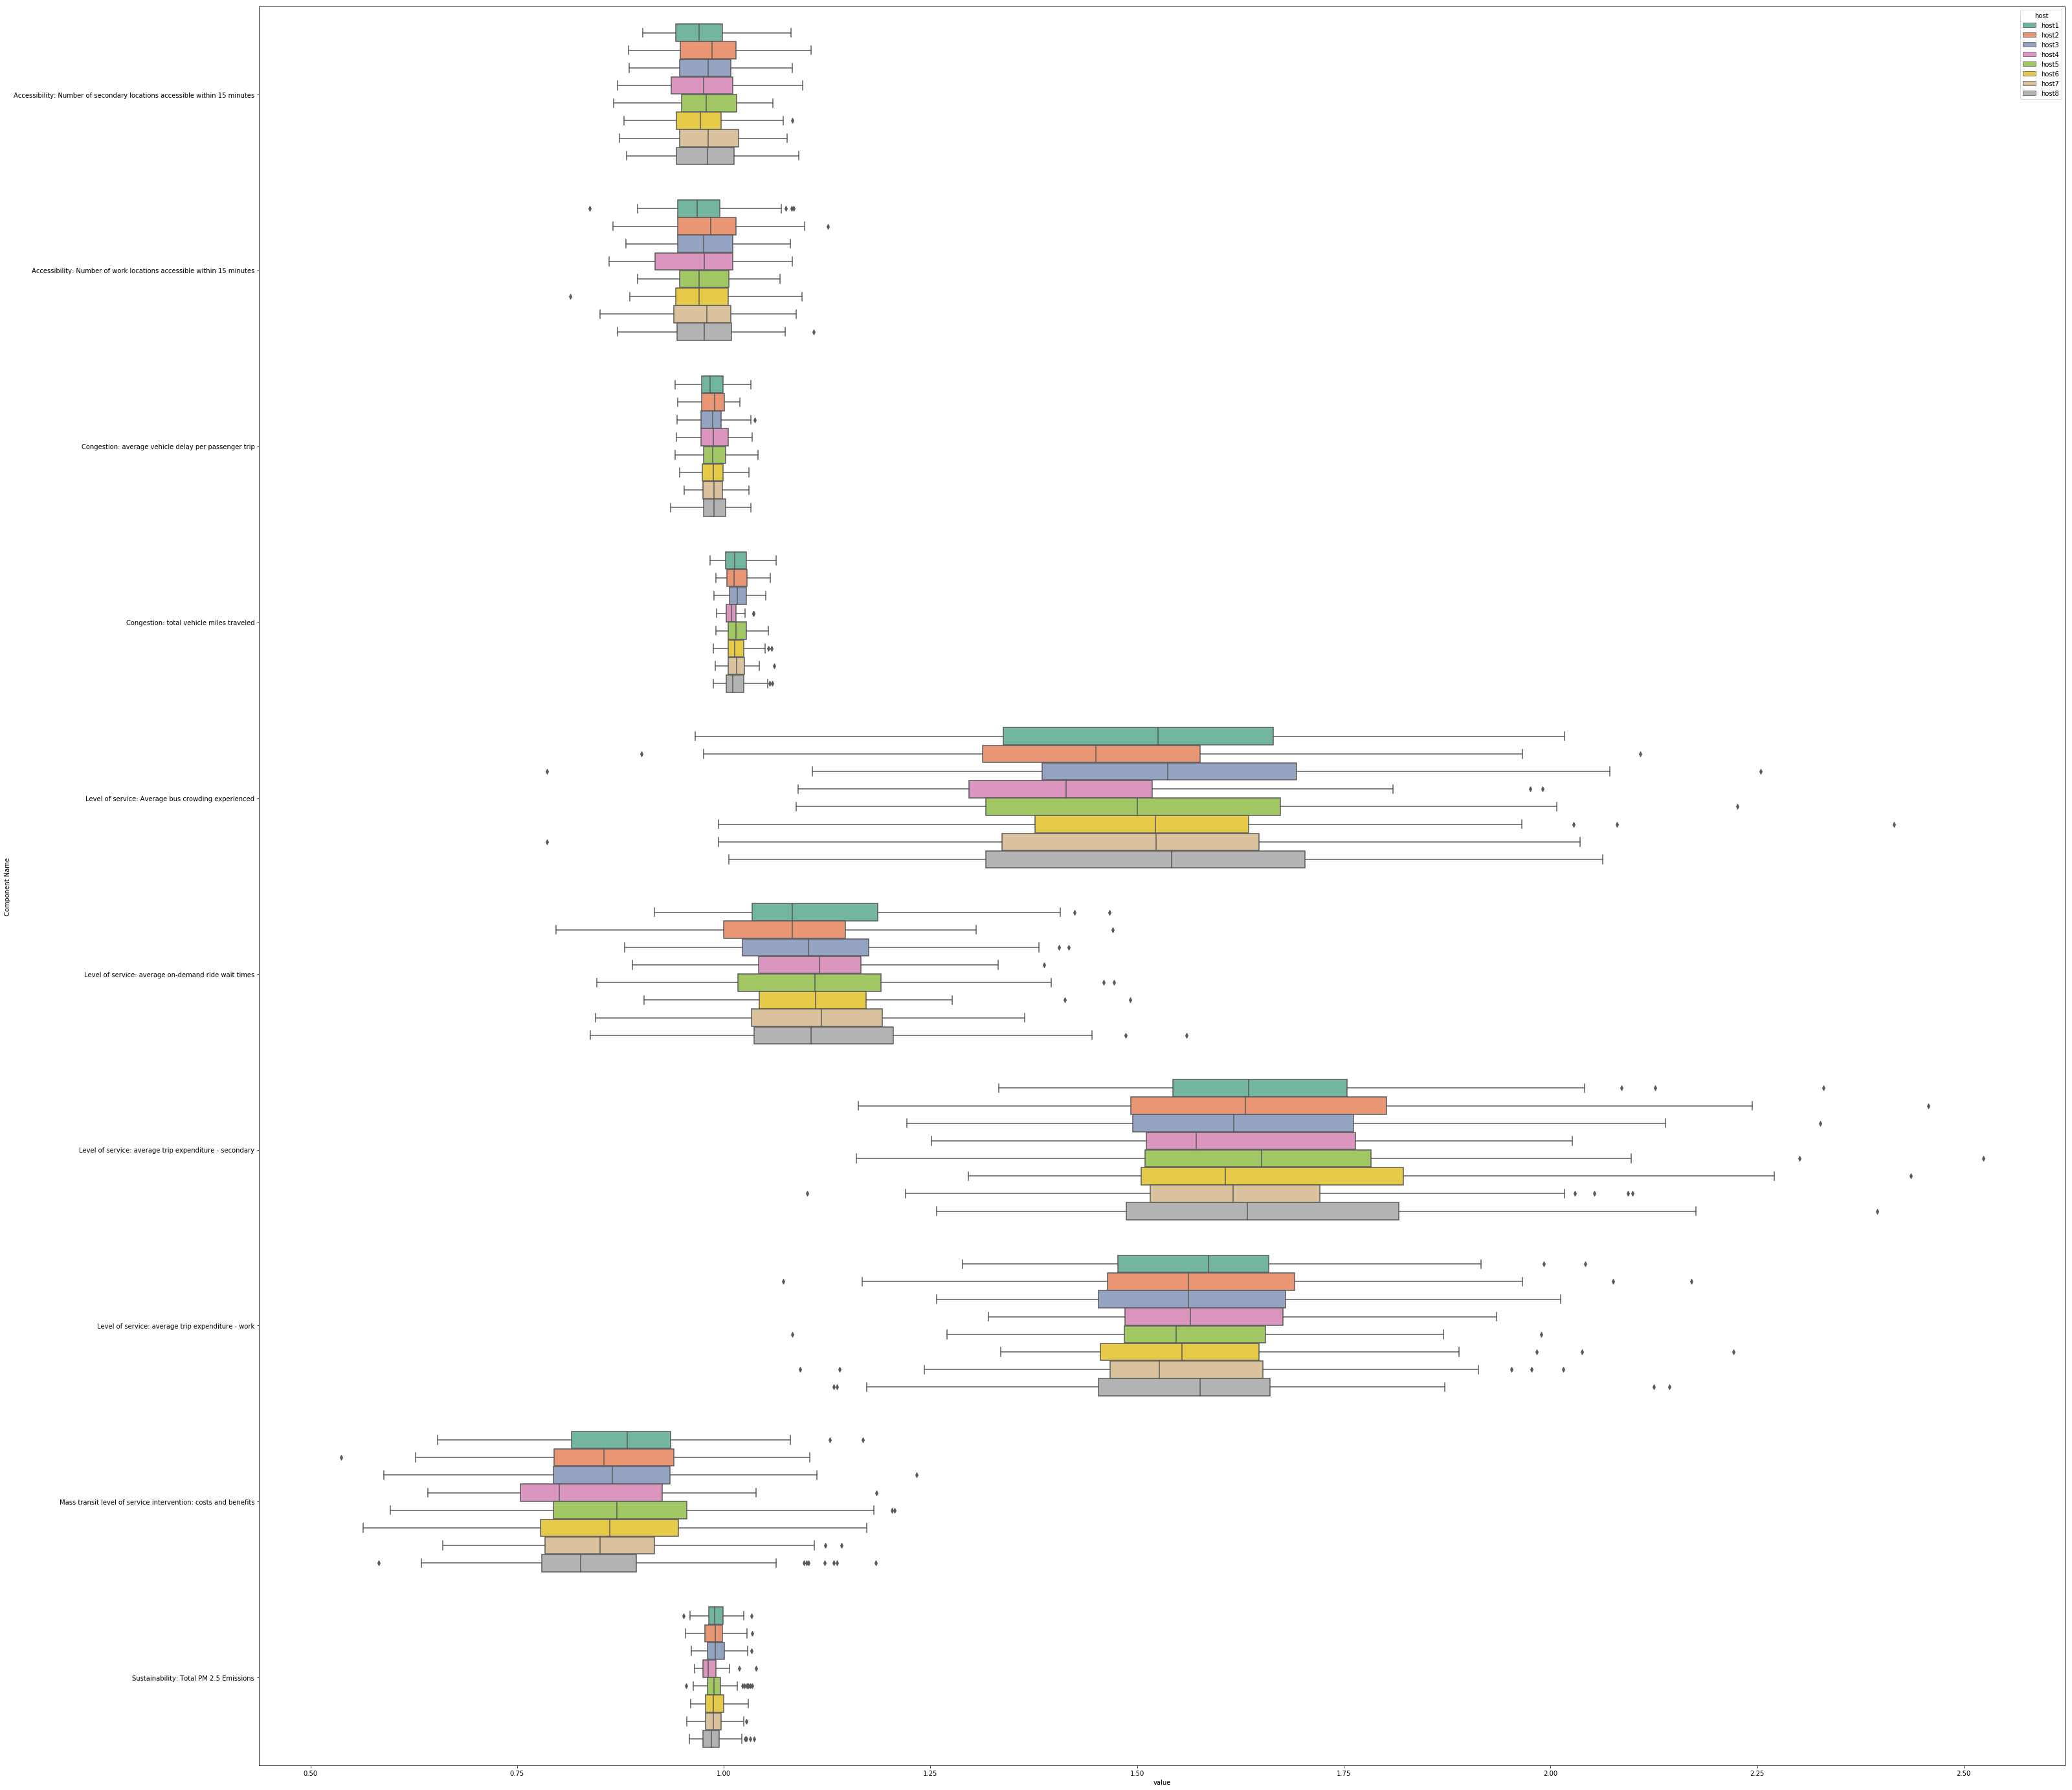

In [13]:
# Create grouped plot
for k,df in scores_dfs.items():
    df['host'] = k
    
grouped = pd.concat(list(scores_dfs.values()))
melted=pd.melt(grouped.drop("Submission Score",axis=1),id_vars='host')
fig = plt.figure(figsize=(50,50))

sns.boxplot(y='Component Name',x='value',hue='host',data=melted,orient='h',palette='Set2')
fig.savefig('img/{}/grouped.png'.format(experiment_type),dpi=300)

In [14]:
wide_scores = pd.concat(list(scores_dfs.values()),axis=0)
wide_scores.to_csv('img/{}/wide_scores.csv'.format(experiment_type))

In [15]:
from pandas.plotting import parallel_coordinates

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

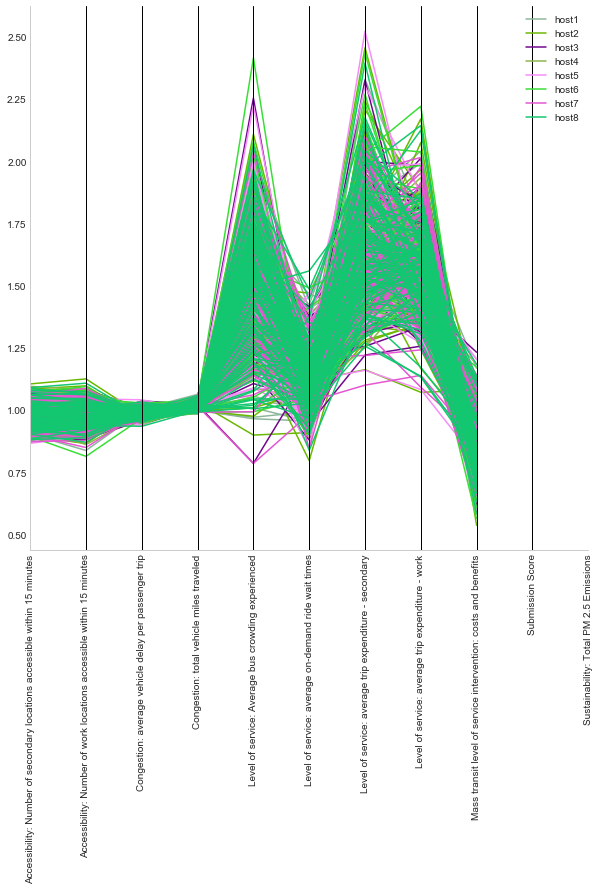

In [16]:
sns.set_palette('Set2')
sns.set_style('whitegrid')
# sns.set_context('notebook')
fig = plt.figure(figsize=(10,10))
axes=parallel_coordinates(wide_scores,'host')
sns.despine()
plt.xticks(rotation=90)



In [37]:
# radar chart
# wide_scores = wide_scores.drop('Submission Score',axis=1)
labels = wide_scores.columns.values[:-1]
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
labels

array(['Accessibility: Number of secondary locations accessible within 15 minutes',
       'Accessibility: Number of work locations accessible within 15 minutes',
       'Congestion: average vehicle delay per passenger trip',
       'Congestion: total vehicle miles traveled',
       'Level of service: Average bus crowding experienced',
       'Level of service: average on-demand ride wait times',
       'Level of service: average trip expenditure - secondary',
       'Level of service: average trip expenditure - work',
       'Mass transit level of service intervention: costs and benefits',
       'Sustainability: Total PM 2.5 Emissions'], dtype=object)

In [39]:
stats = wide_scores.groupby('host').mean()
stats1=stats.loc['host1',labels].values

In [45]:
"""
======================================
Radar chart (aka spider or star chart)
======================================

This example creates a radar chart, also known as a spider or star chart [1]_.

Although this example allows a frame of either 'circle' or 'polygon', polygon
frames don't have proper gridlines (the lines are circles instead of polygons).
It's possible to get a polygon grid by setting GRIDLINE_INTERPOLATION_STEPS in
matplotlib.axis to the desired number of vertices, but the orientation of the
polygon is not aligned with the radial axes.

.. [1] http://en.wikipedia.org/wiki/Radar_chart
"""
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See  doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        labels,
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


if __name__ == '__main__':
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flatten(), data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    ax = axes[0, 0]
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

Component Name,Accessibility: Number of secondary locations accessible within 15 minutes,Accessibility: Number of work locations accessible within 15 minutes,Congestion: average vehicle delay per passenger trip,Congestion: total vehicle miles traveled,Level of service: Average bus crowding experienced,Level of service: average on-demand ride wait times,Level of service: average trip expenditure - secondary,Level of service: average trip expenditure - work,Mass transit level of service intervention: costs and benefits,Sustainability: Total PM 2.5 Emissions
host,,,,,,,,,,
host1,0.974522,0.971895,0.986228,1.015781,1.509418,1.115015,1.663633,1.585041,0.878918,0.990236
host2,0.981603,0.980079,0.987452,1.016046,1.461789,1.087286,1.666289,1.580440,0.865840,0.989209
host3,0.979378,0.976896,0.985014,1.016411,1.527208,1.112715,1.649831,1.567446,0.870109,0.990699
host4,0.976332,0.975627,0.989164,1.010106,1.430312,1.113333,1.629806,1.586009,0.832025,0.985486
host5,0.979666,0.976325,0.988466,1.016676,1.503554,1.114750,1.660809,1.561514,0.881302,0.990530
host6,0.971715,0.972203,0.986437,1.015655,1.519765,1.111926,1.661619,1.575476,0.863785,0.989282
host7,0.982157,0.977119,0.986973,1.015987,1.497608,1.118795,1.629344,1.556425,0.862718,0.988583
host8,0.980291,0.977638,0.988607,1.014426,1.508295,1.128309,1.658552,1.566407,0.847905,0.986561


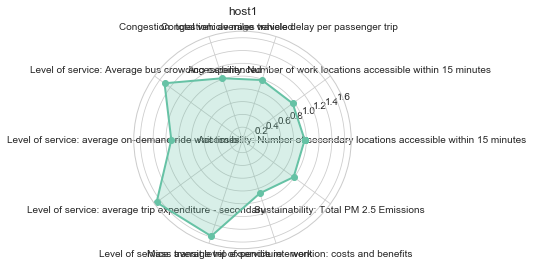

In [51]:
stats1=np.concatenate((stats1,[stats1[0]]))
angles=np.concatenate((angles,[angles[0]]))
fig=plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats1, 'o-', linewidth=2)
ax.fill(angles, stats1, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.set_title(stats.index[0])
ax.grid(True)

In [70]:
from abc import ABCMeta

class InputSampler(ABCMeta):
    
    def __init__(self, gtfs_helper):
        

output_key
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (-0.04, 4.176]
C7_RS5-80wasnxp     (45.834, 50.0]
C7_RS5-80wasnxp     (45.834, 50.0]
C7_RS5-80wasnxp     (45.834, 50.0]
C7_RS5-80wasnxp     (45.834, 50.0]
C7_RS5-80

In [75]:
sub_score_df=sub_score_df.set_index('output_key')
sub_score_df.index.name = 'output_key'

NameError: name 'sub_score_df' is not defined

In [76]:
freq_df=pd.merge(sub_scores["a"],input_db["VehicleFleetMix"],how="outer",right_index=True,left_on=[("output_key")])

NameError: name 'sub_scores' is not defined

In [77]:
freq_df

,trip_id,start_time,end_time,headway_secs
output_key,,,,
1to8baq_,0,29400,67080,5460
1to8baq_,1,0,4140,2160
1to8baq_,2,1740,18360,6480
1to8baq_,3,37680,46320,5460
1to8baq_,4,68580,79320,2820
1to8baq_,5,16680,57060,4200
1to8baq_,6,9240,53940,4500
1to8baq_,7,42600,67680,6480
1to8baq_,8,45780,82080,1920


In [78]:
test_df=freq_df.loc[:,'Weighted Score':].reset_index(drop=True).drop('output_key',axis=1)

KeyError: 'Weighted Score'

In [306]:
test_df["Weighted Score"].describe()

count    1040.000000
mean     1179.355861
std      1450.967800
min         0.000000
25%       271.386123
50%       686.453723
75%      1530.935567
max      7697.940789
Name: Weighted Score, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3d9bfef0>,
      dtype=object)

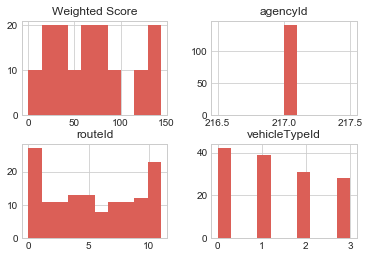

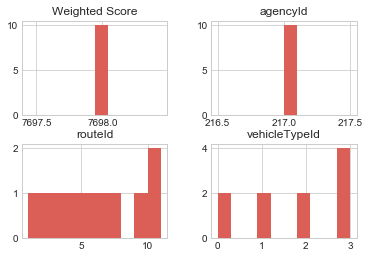

In [310]:
test_df[test_df["Weighted Score"]<150].hist()
test_df[test_df["Weighted Score"]>7030].hist()

-25.328436022934504

In [308]:
test_df[test_df["Weighted Score"]>1571]

,Weighted Score,agencyId,routeId,vehicleTypeId
60,2442.538930,217,10,3
61,2442.538930,217,6,2
62,2442.538930,217,0,1
63,2442.538930,217,9,2
64,2442.538930,217,3,2
65,2442.538930,217,5,1
66,2442.538930,217,11,3
67,2442.538930,217,1,3
68,2442.538930,217,4,1
69,2442.538930,217,2,0
